<a href="https://colab.research.google.com/github/marigold0225/GWdata_Ligo/blob/main/Tuto_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'lalsuite==6.82' 'bilby==1.0.4' 'gwpy==2.0.2'

     |████████████████████████████████| 27.3 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 35.4 MB/s 
     |████████████████████████████████| 1.4 MB 54.0 MB/s 
     |████████████████████████████████| 1.6 MB 30.0 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 
     |████████████████████████████████| 87 kB 4.8 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 3.6 MB 43.9 MB/s 


In [ ]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [ ]:
time_of_event = 1126259462.4

In [ ]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [ ]:
# Definite times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

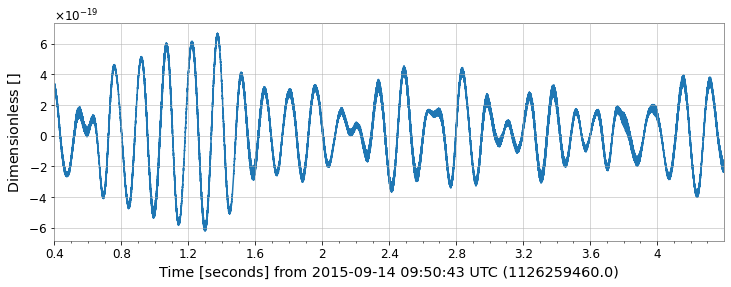

In [ ]:
H1_analysis_data.plot()
plt.show()

In [ ]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

In [ ]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

In [ ]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

In [ ]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

11:51 bilby INFO    : Generating frequency domain strain from given time domain strain.
11:51 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


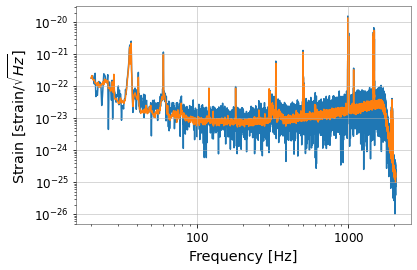

In [ ]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [ ]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

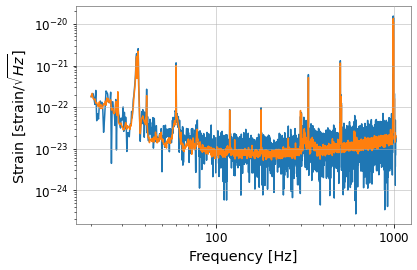

In [ ]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [ ]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066

In [ ]:
# First, put our "data" created above into a list of intererometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

11:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [ ]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

11:52 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
11:52 bilby INFO    : Using lal version 7.1.2
11:52 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
11:52 bilby INFO    : Using lalsimulation version 2.5.1
11:52 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
11:52 bilby INFO    : Search parameters:
11:52 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
11:52 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
11:52 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.00024

0it [00:00, ?it/s]

11:52 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa1b6cb6050>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:52 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:52 bilby INFO    : Using dynesty version 1.1
11:52 bilby INFO    : Resume file short/GW150914_resume.pickle do

922it [00:39, 18.43it/s, bound:0 nc:  1 ncall:3.3e+03 eff:28.2% logz-ratio=266.23+/-0.08 dlogz:3.002>3]

11:52 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
11:52 bilby INFO    : Writing 170 current samples to short/GW150914_samples.dat


922it [00:42, 21.79it/s, bound:0 nc:  1 ncall:3.3e+03 eff:43.6% logz-ratio=268.17+/-0.12 dlogz:0.005>3]

11:52 bilby INFO    : Sampling time: 0:00:32.238494
11:52 bilby INFO    : Reconstructing marginalised parameters.




100%|██████████| 1422/1422 [00:35<00:00, 39.86it/s]

11:53 bilby INFO    : Generating sky frame parameters.



100%|██████████| 1422/1422 [00:00<00:00, 4007.14it/s]


11:53 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 1422/1422 [00:15<00:00, 93.15it/s]


11:53 bilby INFO    : Summary of results:
nsamples: 1422
ln_noise_evidence: -8534.562
ln_evidence: -8266.393 +/-  0.118
ln_bayes_factor: 268.169 +/-  0.118



In [ ]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,dec,ra,theta_jn,psi,luminosity_distance,log_likelihood,log_prior,reference_frequency,waveform_approximant,minimum_frequency,total_mass,mass_1,mass_2,symmetric_mass_ratio,iota,spin_1x,spin_1y,spin_1z,spin_2x,spin_2y,spin_2z,phi_1,phi_2,chi_eff,chi_1_in_plane,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,30.391328,0.601895,0.000011,4.101789,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,261.173973,7.401475,100.0,IMRPhenomPv2,20.0,72.543429,45.286005,27.257423,0.234559,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,41.645262,25.066078,27.948034,66.711340,19.710757+2.755990j,13.726872,14.074984+2.281950j,9.731170
1,30.500772,0.887043,0.000084,5.436853,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,263.840093,7.401475,100.0,IMRPhenomPv2,20.0,70.223453,37.213485,33.009967,0.249104,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,34.221728,30.356149,28.048679,64.577877,19.793987+1.014553j,14.178887,14.337911+1.002446j,10.092893
2,31.216359,0.670330,0.000197,1.181880,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,264.482334,7.401475,100.0,IMRPhenomPv2,20.0,73.446611,43.971310,29.475302,0.240261,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,40.436261,27.105651,28.706737,67.541912,19.962818+1.419274j,14.203853,14.136126+1.115358j,10.072229
3,31.196928,0.656645,-0.000098,1.203517,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,264.858402,7.401475,100.0,IMRPhenomPv2,20.0,73.584908,44.418019,29.166889,0.239261,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,40.847057,26.822033,28.688868,67.669090,19.852177-2.470661j,14.166519,14.073286-1.613953j,10.043137
4,30.941298,0.685047,-0.000032,4.461850,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,265.053285,7.401475,100.0,IMRPhenomPv2,20.0,72.617402,43.095172,29.522229,0.241266,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,39.630560,27.148806,28.453789,66.779366,19.872667+2.362031j,14.129977,14.171136+1.764462j,10.027384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,31.405984,0.980956,-0.000053,2.131828,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,271.017724,7.401475,100.0,IMRPhenomPv2,20.0,72.156005,36.424847,35.731158,0.249977,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,33.496492,32.858572,28.881117,66.355063,19.985014-1.782972j,14.558520,14.261604-1.075747j,10.350256
1418,31.405984,0.980956,-0.000053,5.233460,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,271.017724,7.401475,100.0,IMRPhenomPv2,20.0,72.156005,36.424847,35.731158,0.249977,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,33.496492,32.858572,28.881117,66.355063,20.060412-0.778755j,14.558520,14.304667-0.390464j,10.350256
1419,31.405984,0.980956,-0.000053,1.971816,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,271.017724,7.401475,100.0,IMRPhenomPv2,20.0,72.156005,36.424847,35.731158,0.249977,1.89694,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087423,378.938181,33.496492,32.858572,28.881117,66.355063,19.940233+2.373845j,14.558520,14.202049+1.771941j,10.350256
1420,31.405984,0.980956,-0.000053,5.277311,1.126259e+09,0.0,0.0,0.0,0.0,0.0,0.0,-1.2232,2.19432,1.89694,0.532268,412.066,271.017724,7.401475,100.0,IMRPhenomPv2,20.0,72.156005,36.424847,35.731158,0.249977,1.89694,0,0,0.0

In [ ]:
result_short.posterior["chirp_mass"]

0       30.391328
1       30.500772
2       31.216359
3       31.196928
4       30.941298
          ...    
1417    31.405984
1418    31.405984
1419    31.405984
1420    31.405984
1421    31.405984
Name: chirp_mass, Length: 1422, dtype: float64

In [ ]:
Mc = result_short.posterior["chirp_mass"].values

In [ ]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.440099038488306 with a 90% C.I = 30.97665650043856 -> 31.980814271436586


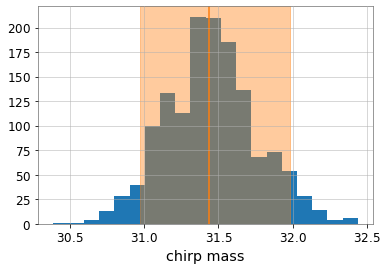

In [ ]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

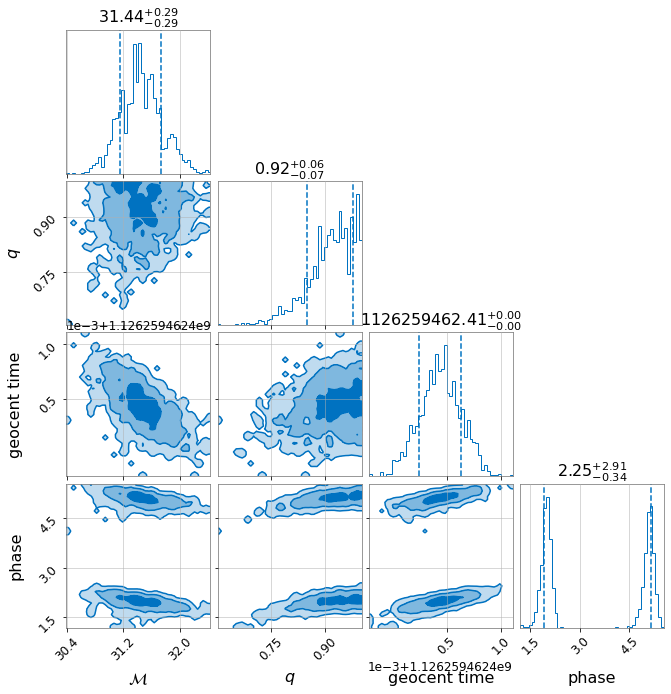

In [ ]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

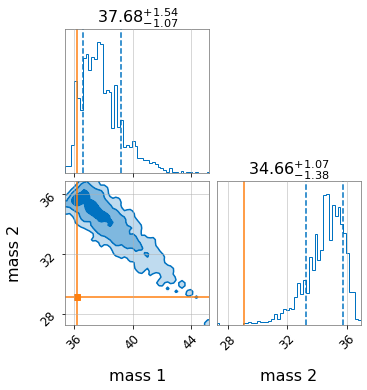

In [ ]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

In [ ]:
result_short.priors

{'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, latex_label=None, unit=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'luminosity_distance': DeltaFunction(peak=412.066, name=None, latex_label=None, unit=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'psi': DeltaFunction(peak=0.

In [ ]:
result_short.sampler_kwargs["nlive"]

500

In [ ]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 268.16900374918396 +/- 0.11822734565325521
